In [72]:
from mrcnn.config import Config
from mrcnn import model as modellib
from mrcnn import visualize
import mrcnn
from mrcnn.utils import Dataset
from mrcnn.model import MaskRCNN
import numpy as np
from numpy import zeros
from numpy import asarray
import colorsys
import argparse
import random
import cv2
import os
import time
from matplotlib import pyplot
from matplotlib.patches import Rectangle
from keras.models import load_model
%matplotlib inline
from os import listdir
from xml.etree import ElementTree
import xml.dom.minidom

In [2]:
class myMaskRCNNConfig(Config):
    # give the configuration a recognizable name
    NAME = "MaskRCNN_config"
 
    # set the number of GPUs to use along with the number of images
    # per GPU
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1
 
    # number of classes (we would normally add +1 for the background)
     # kangaroo + BG
    NUM_CLASSES = 1+1
   
    # Number of training steps per epoch
    STEPS_PER_EPOCH = 131
    
    # Learning rate
    LEARNING_RATE=0.006
    
    # Skip detections with < 90% confidence
    DETECTION_MIN_CONFIDENCE = 0.9
    
    # setting Max ground truth instances
    MAX_GT_INSTANCES=10

In [3]:
config = myMaskRCNNConfig()

In [4]:
config.display()


Configurations:
BACKBONE                       resnet101
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     1
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.9
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 1
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  1024
IMAGE_META_SIZE                14
IMAGE_MIN_DIM                  800
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [1024 1024    3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.006
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE         

In [9]:
class KangarooDataset(Dataset):
    # load the dataset definitions
    def load_dataset(self, dataset_dir, is_train=True):
        
        # Add classes. We have only one class to add.
        self.add_class("dataset", 1, "kangaroo")
        
        # define data locations for images and annotations
        images_dir = dataset_dir + '/images/'
        annotations_dir = dataset_dir + '/annots/'
        
        # Iterate through all files in the folder to 
        #add class, images and annotaions
        for filename in listdir(images_dir):
            
            # extract image id
            image_id = filename[:-4]
            
            # skip bad images
            if image_id in ['00090']:
                continue
            # skip all images after 150 if we are building the train set
            if is_train and int(image_id) >= 150:
                continue
            # skip all images before 150 if we are building the test/val set
            if not is_train and int(image_id) < 150:
                continue
            
            # setting image file
            img_path = images_dir + filename
            
            # setting annotations file
            ann_path = annotations_dir + image_id + '.xml'
            
            # adding images and annotations to dataset
            self.add_image('dataset', image_id=image_id, path=img_path, annotation=ann_path)
# extract bounding boxes from an annotation file
    def extract_boxes(self, filename):
        
        # load and parse the file
        tree = ElementTree.parse(filename)
        # get the root of the document
        root = tree.getroot()
        # extract each bounding box
        boxes = list()
        for box in root.findall('.//bndbox'):
            xmin = int(box.find('xmin').text)
            ymin = int(box.find('ymin').text)
            xmax = int(box.find('xmax').text)
            ymax = int(box.find('ymax').text)
            coors = [xmin, ymin, xmax, ymax]
            boxes.append(coors)
        
        # extract image dimensions
        width = int(root.find('.//size/width').text)
        height = int(root.find('.//size/height').text)
        return boxes, width, height
# load the masks for an image
    """Generate instance masks for an image.
       Returns:
        masks: A bool array of shape [height, width, instance count] with
            one mask per instance.
        class_ids: a 1D array of class IDs of the instance masks.
     """
    def load_mask(self, image_id):
        # get details of image
        info = self.image_info[image_id]
        
        # define anntation  file location
        path = info['annotation']
        
        # load XML
        boxes, w, h = self.extract_boxes(path)
       
        # create one array for all masks, each on a different channel
        masks = zeros([h, w, len(boxes)], dtype='uint8')
        
        # create masks
        class_ids = list()
        for i in range(len(boxes)):
            box = boxes[i]
            row_s, row_e = box[1], box[3]
            col_s, col_e = box[0], box[2]
            masks[row_s:row_e, col_s:col_e, i] = 1
            class_ids.append(self.class_names.index('kangaroo'))
        return masks, asarray(class_ids, dtype='int32')
    # load an image reference
    def image_reference(self, image_id):
        info = self.image_info[image_id]
        print(info)
        return info['path']

In [6]:
dataset_dir = './kangaroo-master/'

(300, 450, 3)
(300, 450, 4)


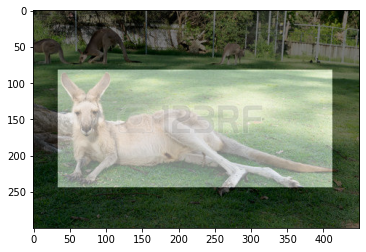

In [15]:
# train set
train_set = KangarooDataset()
train_set.load_dataset('kangaroo-master', is_train = True)
train_set.prepare()

# load an image
image_id = 0
image = train_set.load_image(image_id)
print(image.shape)
# load image mask
mask, class_ids = train_set.load_mask(image_id)
print(mask.shape)
# plot image
pyplot.imshow(image)
# plot mask
pyplot.imshow(mask[:, :, 0], cmap = 'gray', alpha = 0.5)
pyplot.show()

In [8]:
!ls

 2081198423_d0cc871dbd_o.jpg
 assets
 build
 coco-master
 coco-master.zip
 dist
'Document Layout Analyser.ipynb'
 images
 kangaroo-master
 LICENSE
 MANIFEST.in
 mask_rcnn_coco.h5
 mask_rcnn.egg-info
 mrcnn
 README.md
 requirements.txt
 samples
 setup.cfg
 setup.py
'This is the elephant who charged us _ Mandy Goldberg _ Flickr_files'
 Untitled.ipynb


In [131]:
class KangarooDataset(Dataset):
    # load the dataset definitions
    def load_dataset(self, dataset_dir, is_train=True):
        
        # Add classes. We have only one class to add.
        self.add_class("dataset", 1, "kangaroo")
        
        # define data locations for images and annotations
        images_dir = dataset_dir + '/images1/'
        annotations_dir = dataset_dir + '/annots1/'
        
        # Iterate through all files in the folder to 
        #add class, images and annotaions
        for filename in listdir(images_dir):
            
            # extract image id
            image_id = filename[:-4]
            
            # setting image file
            img_path = images_dir + filename
            
            # setting annotations file
            ann_path1 = annotations_dir + image_id + '.xml'
            ann_path2 = annotations_dir + 'pc-' + image_id + '.xml'
            # adding images and annotations to dataset
            if(os.path.exists(ann_path1)):
                # print('YES0')
                # print(ann_path1)
                self.add_image('dataset', image_id=image_id, path=img_path, annotation=ann_path1)
            elif(os.path.exists(ann_path2)):
                # print('YES1')
                # print(ann_path2)
                self.add_image('dataset', image_id=image_id, path=img_path, annotation=ann_path2)
# extract bounding boxes from an annotation file
    def extract_boxes(self, filename):
        
        # load and parse the file
        # tree = ElementTree.parse(filename)
        doc = xml.dom.minidom.parse(filename)
        # get the root of the document
        # root = tree.getroot()
        # extract each bounding box
        boxes = list()
        x = []
        y = []
        for dims in doc.getElementsByTagName('Coords'):
            for dim in doc.getElementsByTagName('Point'):
                x.append(int(dim.getAttribute('x')))
                y.append(int(dim.getAttribute('y')))
        boxes = [min(x), min(y), max(x), max(y)]
            
        # extract image dimensions
        print(boxes)
        Page = doc.getElementsByTagName('Page')
        for page in Page:
            width = page.getAttribute('imageWidth')
            height = page.getAttribute('imageHeight')
        print('Width = ', width)
        print('Height = ', height)
        return boxes, width, height
# load the masks for an image
    """Generate instance masks for an image.
       Returns:
        masks: A bool array of shape [height, width, instance count] with
            one mask per instance.
        class_ids: a 1D array of class IDs of the instance masks.
     """
    def load_mask(self, image_id):
        # get details of image
        info = self.image_info[image_id]
        
        # define anntation  file location
        path = info['annotation']
        
        # load XML
        boxes, w, h = self.extract_boxes(path)
        print(boxes, w, h)
        # create one array for all masks, each on a different channel
        masks = zeros((h, w), dtype='uint8')
        
        # create masks
        class_ids = list()
        for i in range(len(boxes)):
            box = boxes[i]
            row_s, row_e = box[1], box[3]
            col_s, col_e = box[0], box[2]
            masks[row_s:row_e, col_s:col_e, i] = 1
            class_ids.append(self.class_names.index('kangaroo'))
        return masks, asarray(class_ids, dtype='int32')
    # load an image reference
    def image_reference(self, image_id):
        info = self.image_info[image_id]
        print(info)
        return info['path']

(3196, 2242, 3)
[33, 109, 2173, 3075]
Width =  2242
Height =  3196
[33, 109, 2173, 3075] 2242 3196


TypeError: 'str' object cannot be interpreted as an integer

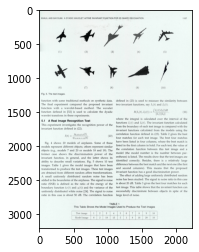

In [134]:
# train set
train_set = KangarooDataset()
train_set.load_dataset('kangaroo-master', is_train = True)
train_set.prepare()

# load an image
image_id = 4
image = train_set.load_image(image_id)
pyplot.imshow(image)
print(image.shape)
# load image mask
mask, class_ids = train_set.load_mask(image_id)
print(mask.shape)
# plot image
pyplot.imshow(image)
# plot mask
pyplot.imshow(mask[:, :, 0], cmap = 'gray', alpha = 0.5)
pyplot.show()

In [126]:
hell = zeros((2,2))
hell

array([[0., 0.],
       [0., 0.]])